In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa



# 2 Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias 

In [36]:
#agbarometer

df_agbarometer = pd.read_csv('../data/clean_data/agbarometer_cleaned.csv')
print(df_agbarometer.head())

     Bimestre  CondicIones presentes  Expectativas futuras  Ag Barometer
0  2018-11-01                     43                   130            95
1  2019-01-01                     59                   137           106
2  2019-03-01                     69                   126           103
3  2019-05-01                     82                   141           117
4  2019-07-01                    105                   158           137


In [37]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bimestre               41 non-null     object
 1   CondicIones presentes  41 non-null     int64 
 2   Expectativas futuras   41 non-null     int64 
 3   Ag Barometer           41 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ KB


In [38]:
print(df_agbarometer['Bimestre'].head())

0    2018-11-01
1    2019-01-01
2    2019-03-01
3    2019-05-01
4    2019-07-01
Name: Bimestre, dtype: object


In [39]:
df_agbarometer['Bimestre'] = pd.to_datetime(df_agbarometer['Bimestre'], format='%Y-%m-%d')
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bimestre               41 non-null     datetime64[ns]
 1   CondicIones presentes  41 non-null     int64         
 2   Expectativas futuras   41 non-null     int64         
 3   Ag Barometer           41 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 KB


In [40]:
df_agbarometer.set_index('Bimestre', inplace=True)
df_agbarometer.head()

,CondicIones presentes,Expectativas futuras,Ag Barometer
Bimestre,,,
2018-11-01,43,130,95
2019-01-01,59,137,106
2019-03-01,69,126,103
2019-05-01,82,141,117
2019-07-01,105,158,137


In [41]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2018-11-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CondicIones presentes  41 non-null     int64
 1   Expectativas futuras   41 non-null     int64
 2   Ag Barometer           41 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


In [42]:
data1 = df_agbarometer['Ag Barometer']

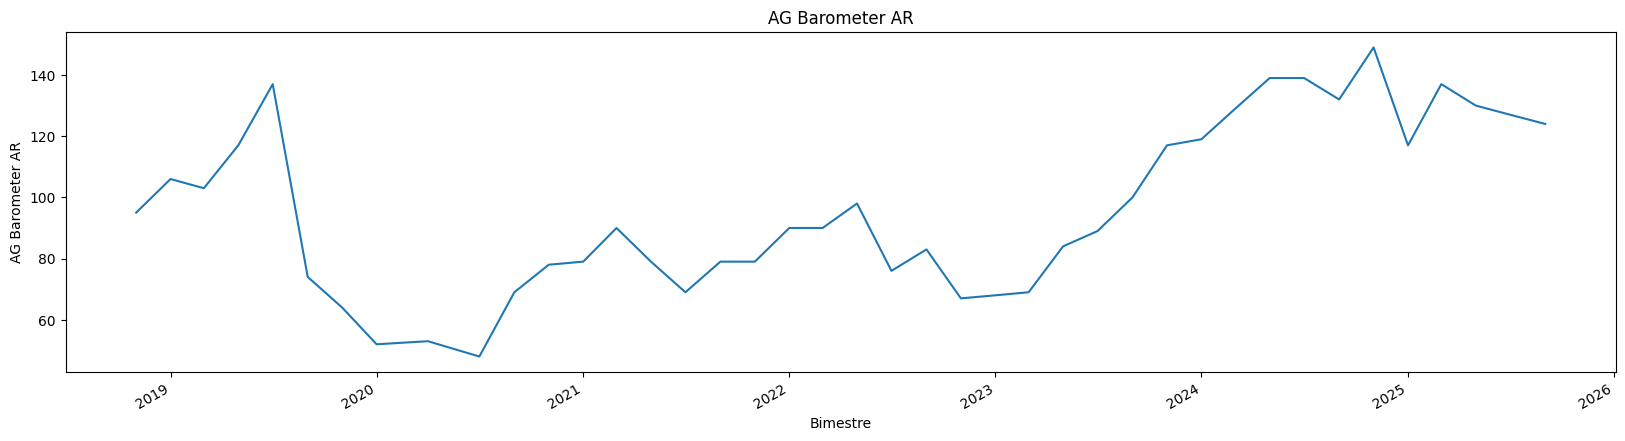

In [43]:
data1.plot(figsize=(20,5), title = "AG Barometer AR", ylabel = "AG Barometer AR", xlabel = "Bimestre")
plt.show()

In [44]:
#ageconomy

df_ageconomy = pd.read_csv('../data/clean_data/AgEconomyBarometer_cleaned.csv')
print(df_ageconomy.head())

      Month  Year  Purdue/CME Ag Economy Barometer  \
0   October  2015                              116   
1  November  2015                               97   
2  December  2015                              107   
3   January  2016                               98   
4  February  2016                               96   

   Index of Current Conditions  Index of Future Expectations  \
0                          118                           116   
1                           98                            97   
2                          125                            98   
3                           99                            98   
4                           82                           102   

   Farm Capital Investment Index  
0                             67  
1                             51  
2                             75  
3                             52  
4                             56  


In [45]:
df_ageconomy['Date'] = df_ageconomy['Year'].astype(str) + '-' + df_ageconomy['Month'].astype(str).str.zfill(2) + '-01'
df_ageconomy['Date'] = pd.to_datetime(df_ageconomy['Date'])

In [46]:
df_ageconomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Month                            121 non-null    object        
 1   Year                             121 non-null    int64         
 2   Purdue/CME Ag Economy Barometer  121 non-null    int64         
 3   Index of Current Conditions      121 non-null    int64         
 4   Index of Future Expectations     121 non-null    int64         
 5   Farm Capital Investment Index    121 non-null    int64         
 6   Date                             121 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.7+ KB


In [47]:
df_ageconomy.set_index('Date', inplace=True)
df_ageconomy.head()

,Month,Year,Purdue/CME Ag Economy Barometer,Index of Current Conditions,Index of Future Expectations,Farm Capital Investment Index
Date,,,,,,
2015-10-01,October,2015,116,118,116,67
2015-11-01,November,2015,97,98,97,51
2015-12-01,December,2015,107,125,98,75
2016-01-01,January,2016,98,99,98,52
2016-02-01,February,2016,96,82,102,56


In [48]:
data2 = df_ageconomy['Purdue/CME Ag Economy Barometer']

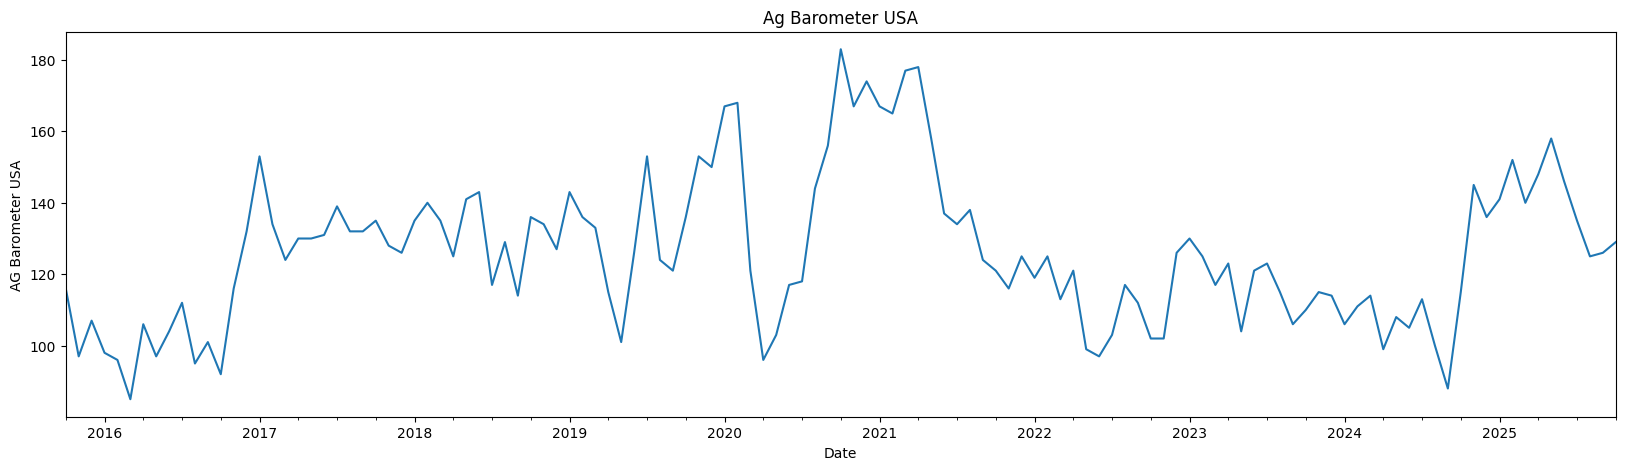

In [49]:
data2.plot(figsize=(20,5), title = "Ag Barometer USA", ylabel = "AG Barometer USA", xlabel = "Date")
plt.show()

In [50]:
#ICG UTDT

df_ICG = pd.read_csv('../data/clean_data/ICG_cleaned.csv')
print(df_ICG.head())

  indicator        date  value
0       ICG  2001-11-01  1.036
1       ICG  2001-12-01  0.757
2       ICG  2002-01-01  1.357
3       ICG  2002-02-01  0.983
4       ICG  2002-03-01  0.862


In [51]:
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   indicator  288 non-null    object 
 1   date       288 non-null    object 
 2   value      288 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.9+ KB


In [52]:
df_ICG['date'] = pd.to_datetime(df_ICG['date'], format='%Y-%m-%d')
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   indicator  288 non-null    object        
 1   date       288 non-null    datetime64[ns]
 2   value      288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.9+ KB


In [53]:
df_ICG.set_index('date', inplace=True)
print(df_ICG.head())

           indicator  value
date                       
2001-11-01       ICG  1.036
2001-12-01       ICG  0.757
2002-01-01       ICG  1.357
2002-02-01       ICG  0.983
2002-03-01       ICG  0.862


In [54]:
data3 = df_ICG['value']

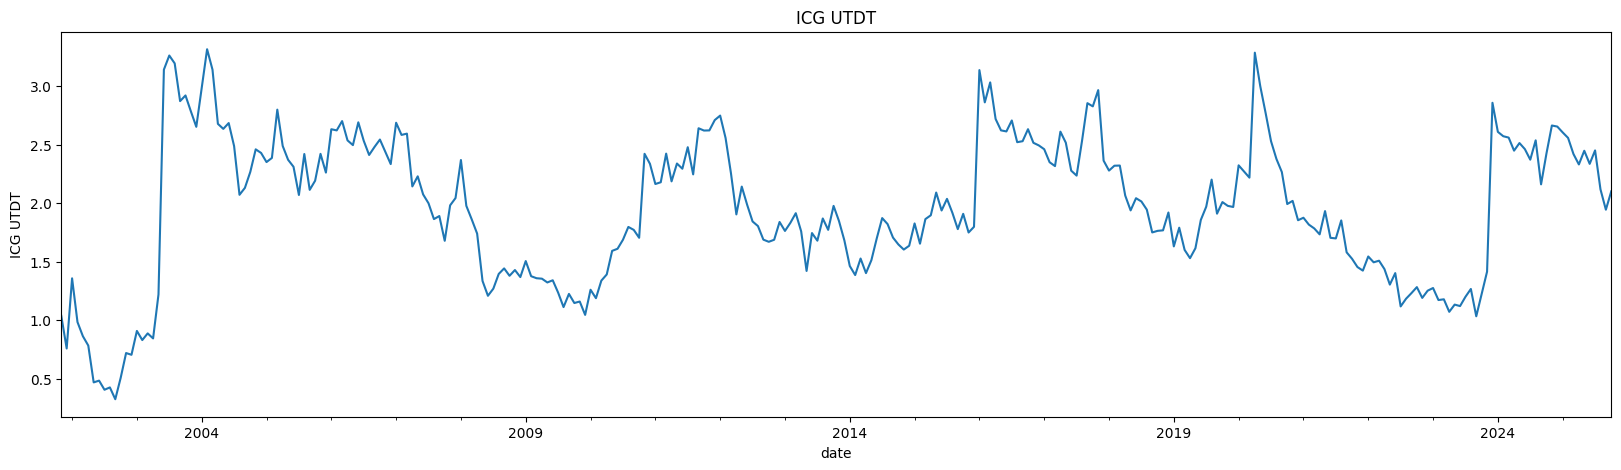

In [55]:
data3.plot(figsize=(20,5), title = "ICG UTDT", ylabel = "ICG UTDT", xlabel = "date")
plt.show()

En este apartado se presentan las siguientes series, en orden:

- Ag Barometer AR
- Ag Barometer USA
- ICG

La primera parece tener una componente de tendencia, aparentemente lineal, lo que implicaría que la serie no es estacionaria. Pero al tener esta leve tendencia y, visualmente, no notarse ciclos, con una diferenciación tal vez pueda ser necesario para hacer a la misma estacionaria.

Para Ag Baromemter USA, la seria aparenta ser estacionaria. Tal vez puede existir una leve componente de tendencia o alguna variación en variabilidad pero, a priori, se asemeja mucho a una estacionaria. Para ese caso no necesitariamos diferenciación.

Por otro lado, tenemos el ICG, que a simple vista no parece ser estacionaria. Si bien podriamos pensar en cierta oscilación sobre una valor medio, parece tener ciclos de picos y valles, con saltos absolutos marcados sobre años de elecciones presidenciales. En este caso, una prueba a hacer sería diferenciar entre los valores del ciclo, para reducir dicha estacionalidad.

# 3 Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría. 

In [56]:
# Grafica de ACF, PACF y autocovarianza
def graficar_acf_pacf_autocovarianza(data, lags=10):
    Y = data.values

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))


    sm.graphics.tsa.plot_acf(Y, lags=lags, ax=ax[0])
    ax[0].set_title('Funcion de autocorrelación (ACF)')

    sm.graphics.tsa.plot_pacf(Y, lags=lags, ax=ax[1])
    ax[1].set_title('Funcion de autocorrelación Parcial (grafico introductorio) (PACF)')

    def autocovariance(series, lag):
        series_mean = np.mean(series)
        n = len(series)
        return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

    lags = np.arange(lags)
    autocov = [autocovariance(Y, lag) for lag in lags]

    ax[2].stem(lags, autocov)
    ax[2].set_title('Autocovarianza')
    ax[2].set_xlabel('Lag')
    ax[2].set_ylabel('Autocovarianza')

    plt.tight_layout();
    plt.show();

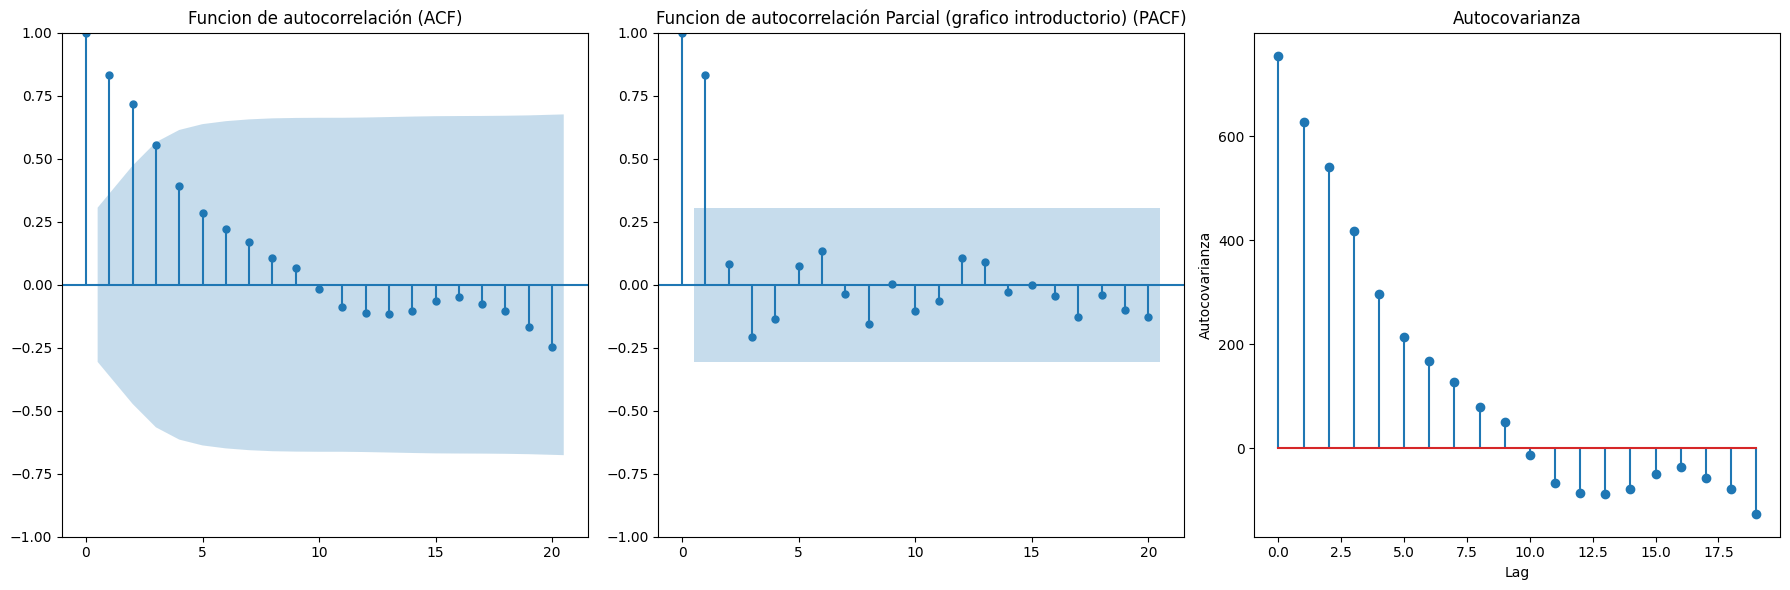

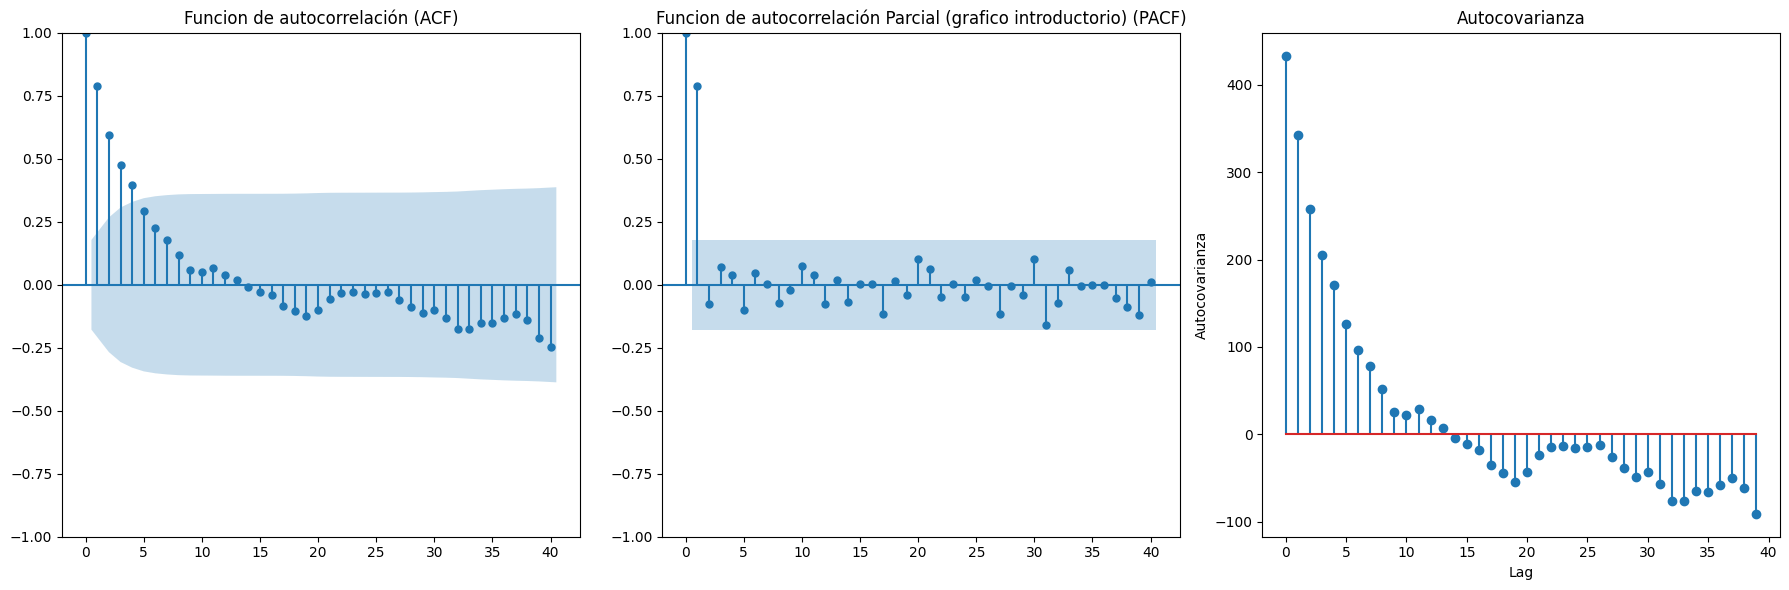

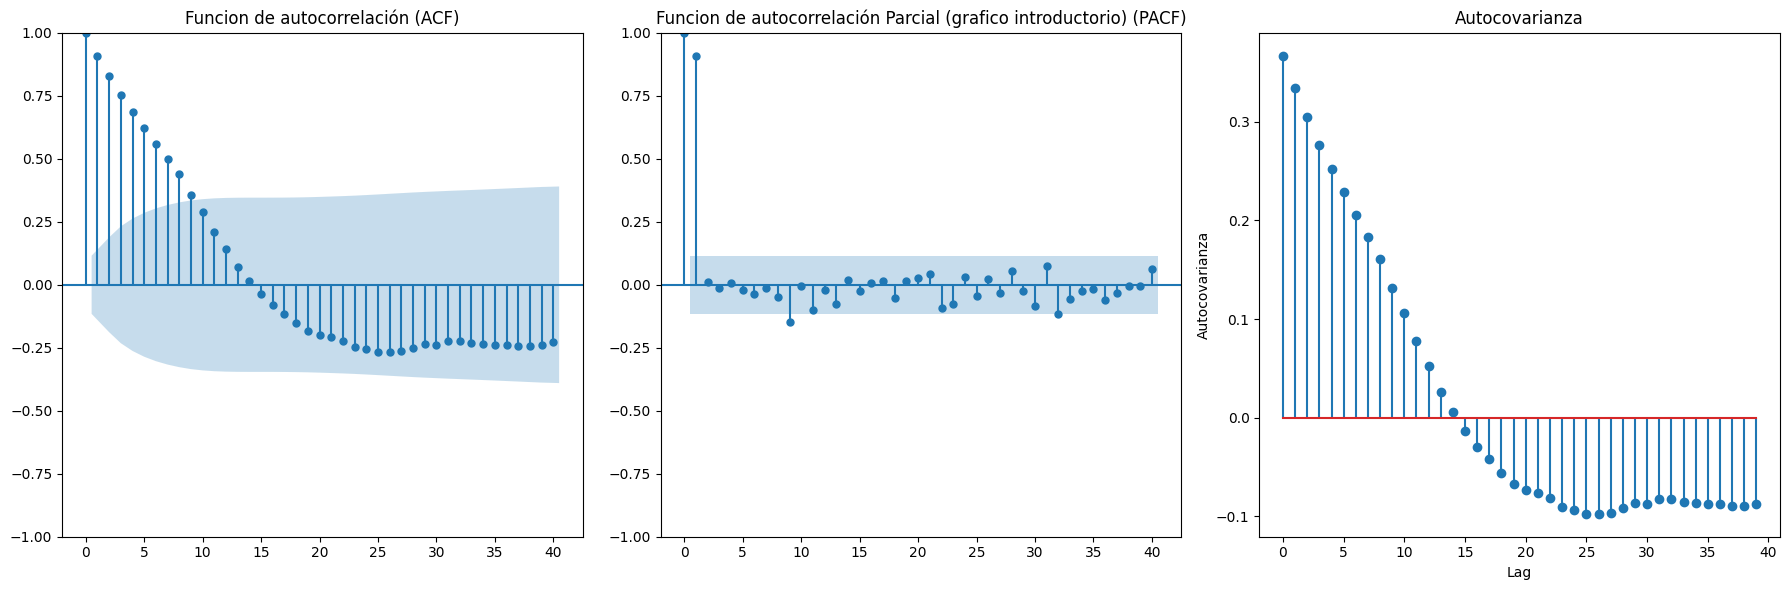

In [57]:
graficar_acf_pacf_autocovarianza(data1, lags=20)
graficar_acf_pacf_autocovarianza(data2, lags=40)
graficar_acf_pacf_autocovarianza(data3, lags=40)

En el caso del Ag Barometer AR podemos ver un decaimiento que aparenta ser lineal, lo que ya nos puede hacer pensar en que no tenemos estacionariedad. A su vez, vemos una fuerte autocorrelación parcial con el primer rezago, haciendonos pensar en una componente autorregresiva de orden 1.

El caso del Ag Barometer USA podría indicarnos una serie estacionaria, donde se nota un decaimiento exponencial en el correlograma, con memoria relativamente corta. A su vez, otra vez visualizando la autocorrelación parcial, podemos pensar en una autocorrelación de orden 1. Con todo esto, pensamos que un primer modelo de aproximación podría ser un AR(1)

Para el caso del ICG, vemos más una caida lineal de la autocorrelación y algunos rezagos estadísticamente significativos en la autocorrelación parcial. Este es el caso más dificil de interpretar, ya que la supuesta estacionalidad marcada tampoco se ve muy notoriamente en estos gráficos

In [58]:
print_test_afd(data1)
print_test_afd(data2)
print_test_afd(data3)

Estadistico ADF: -1.025895
p-valor: 0.743703
Valores criticos:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Estadistico ADF: -3.727040
p-valor: 0.003748
Valores criticos:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Estadistico ADF: -3.752162
p-valor: 0.003436
Valores criticos:
	1%: -3.453
	5%: -2.872
	10%: -2.572


Recordando que el test de Dickey-Fuller involucra:

- H0: existencia de raiz unitaria
- Ha: no existencia de raiz unitaria

Dados los p valores de los test a las 3 series, podemos decir que:

- Para AG Barometer AR, no podemos rechazar la H0, o sea, la no estacionariedad
- Para AG Barometer USA e ICG, se presenta evidencia estadística para rechazar H0 y afirmar que presentan estacionariedad